In [1]:
# Essential packages
import pandas as pd
import numpy as np

# Plot packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Pre-processing packages
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Packages for handling missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
# Packages for Machine Learning
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
import lazypredict
from lazypredict.Supervised import LazyClassifier


# Models 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Model optimization package
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [4]:
data = pd.read_csv("bank.csv",sep = ',')
data.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
miss_val = data.isnull().any().sum()
miss_val

0

In [7]:
data_categorical = data.select_dtypes(include='object')
data_numeric = data.select_dtypes(include='int64')
col_cat = data_categorical.columns 
col_num = data_numeric.columns

In [8]:
data_categorical = data.select_dtypes(include='object')
data_numeric = data.select_dtypes(include='int64')
col_cat = data_categorical.columns 
col_num = data_numeric.columns

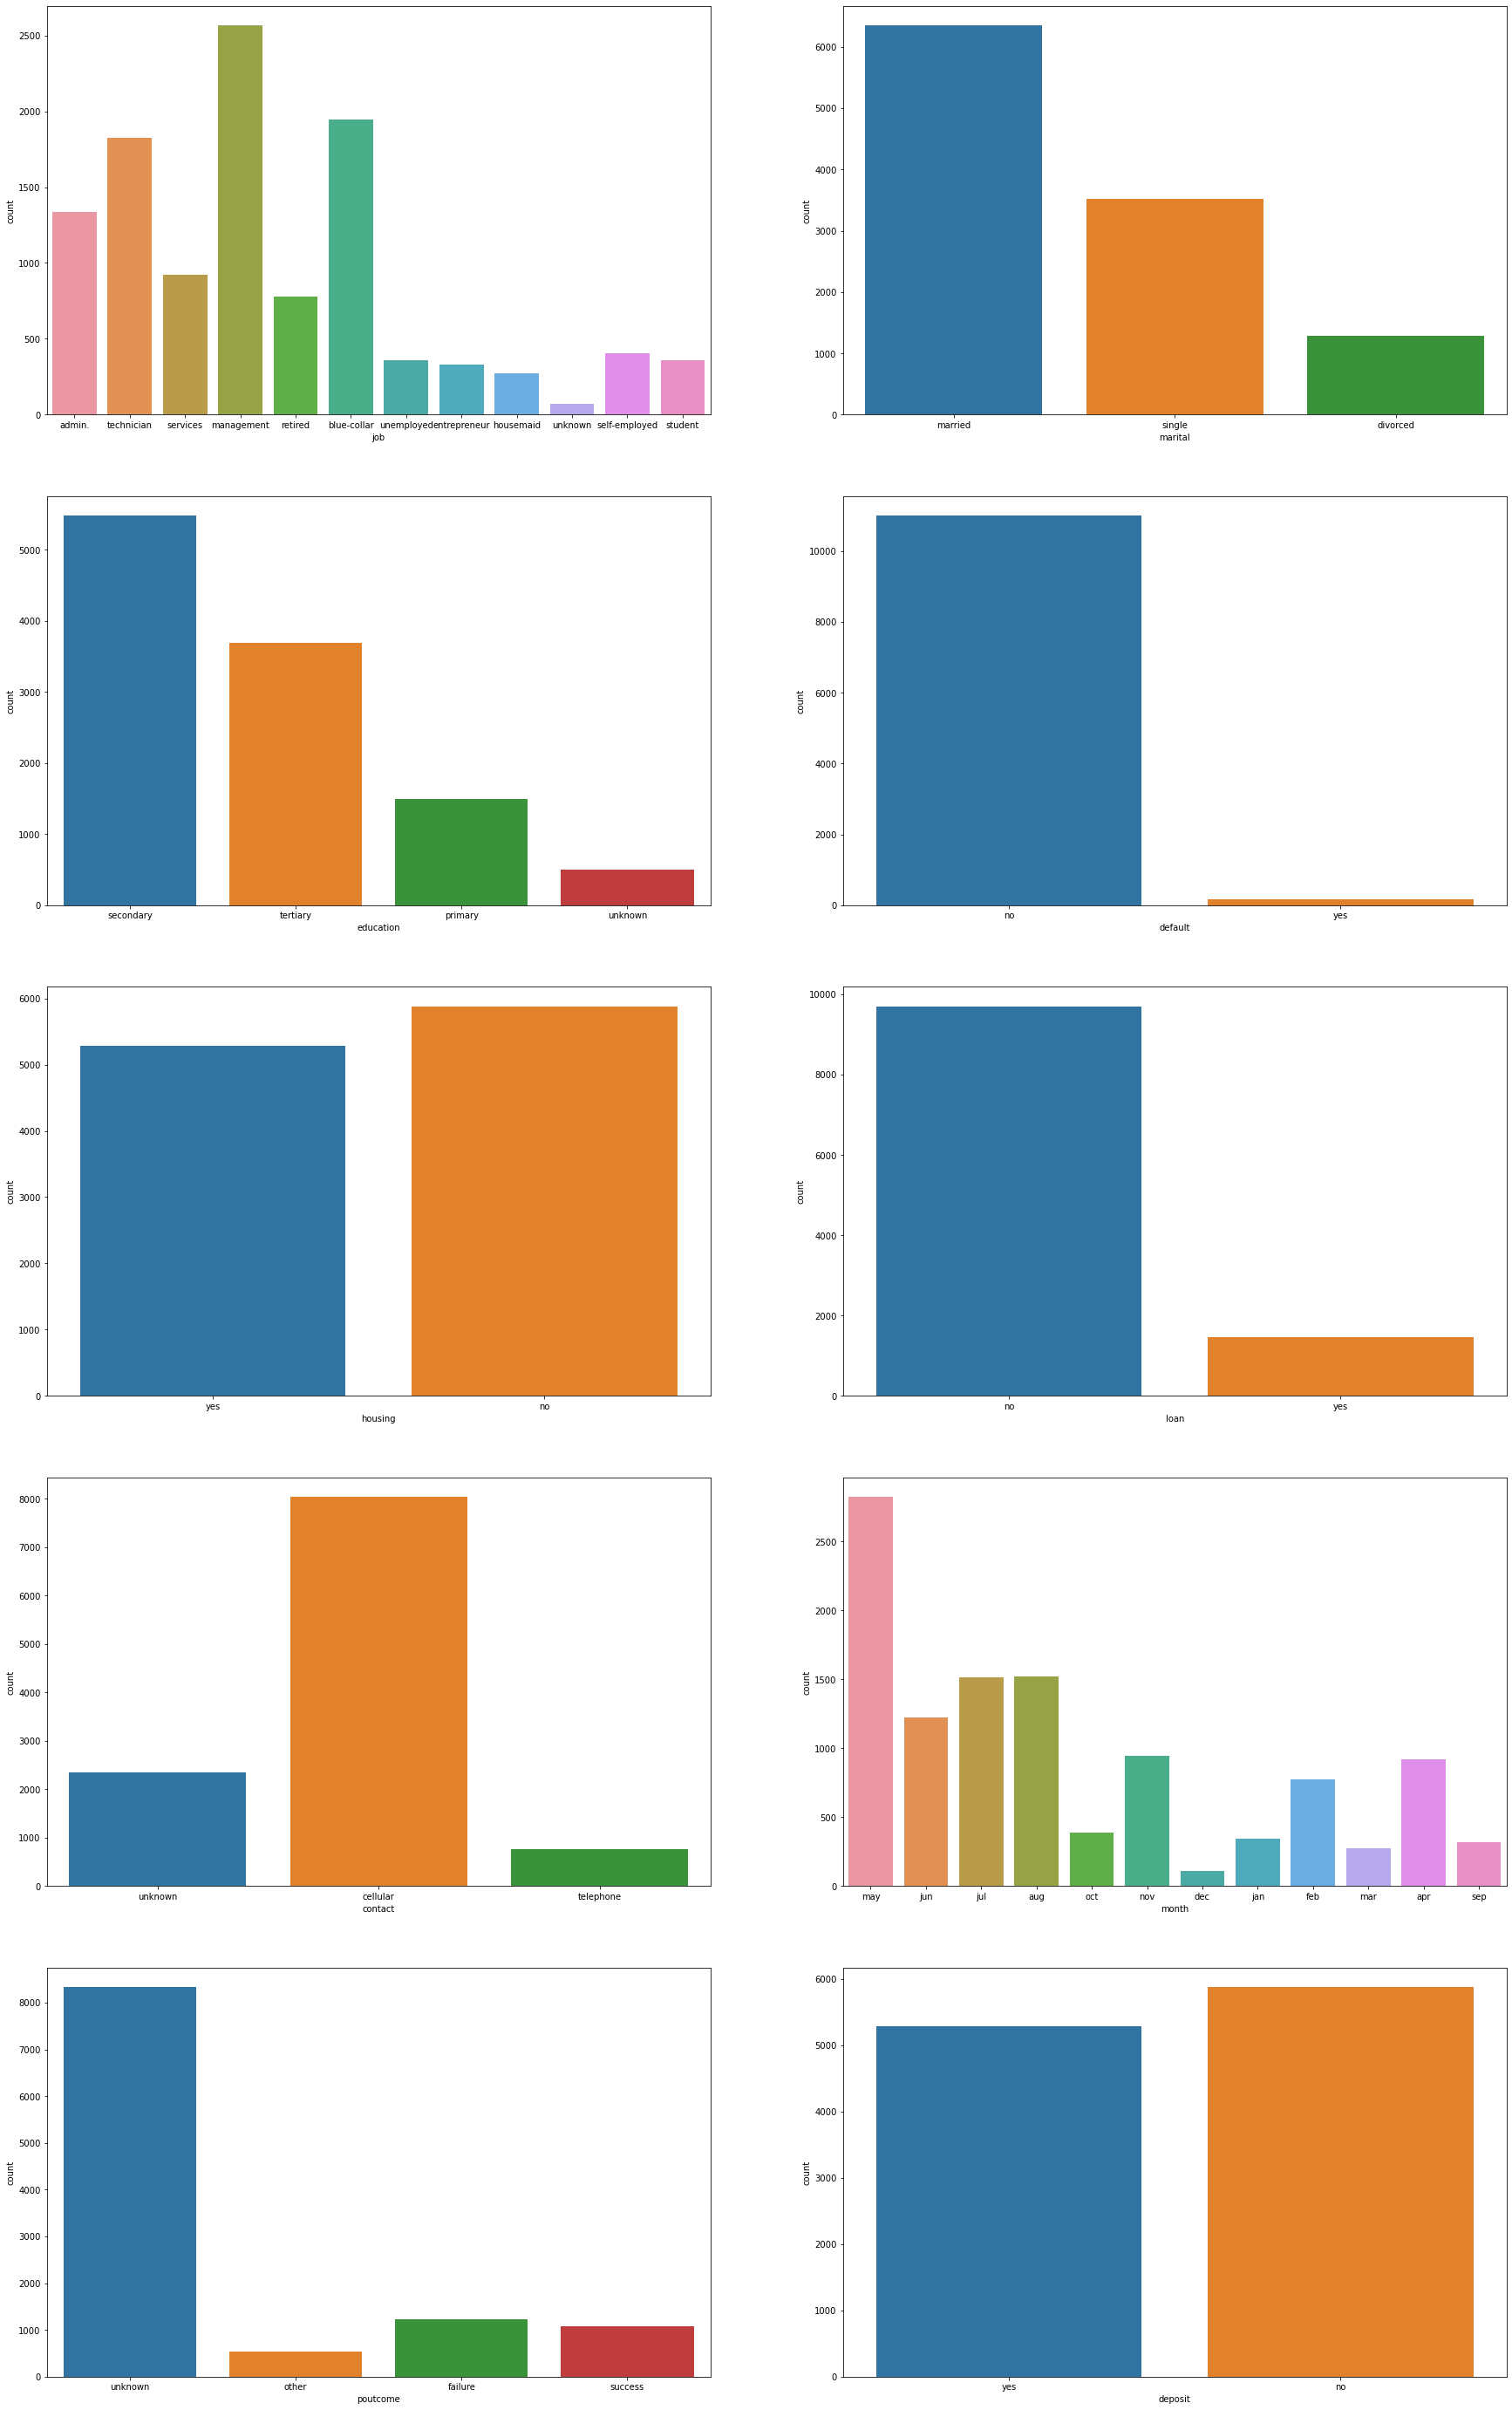

In [9]:
n = len(col_cat)
fig, ax = plt.subplots(round(n/2), 2, figsize = (30,50), sharey = False)
axes = ax.flatten()

for i in range(0,n):
    sns.countplot(data = data, x = col_cat[i], ax = axes[i])

In [10]:
data['poutcome'] = data['poutcome'].replace({'unknown':np.NaN, 'other':np.NaN})
data['contact'] = data['contact'].replace('unknown',np.NaN)

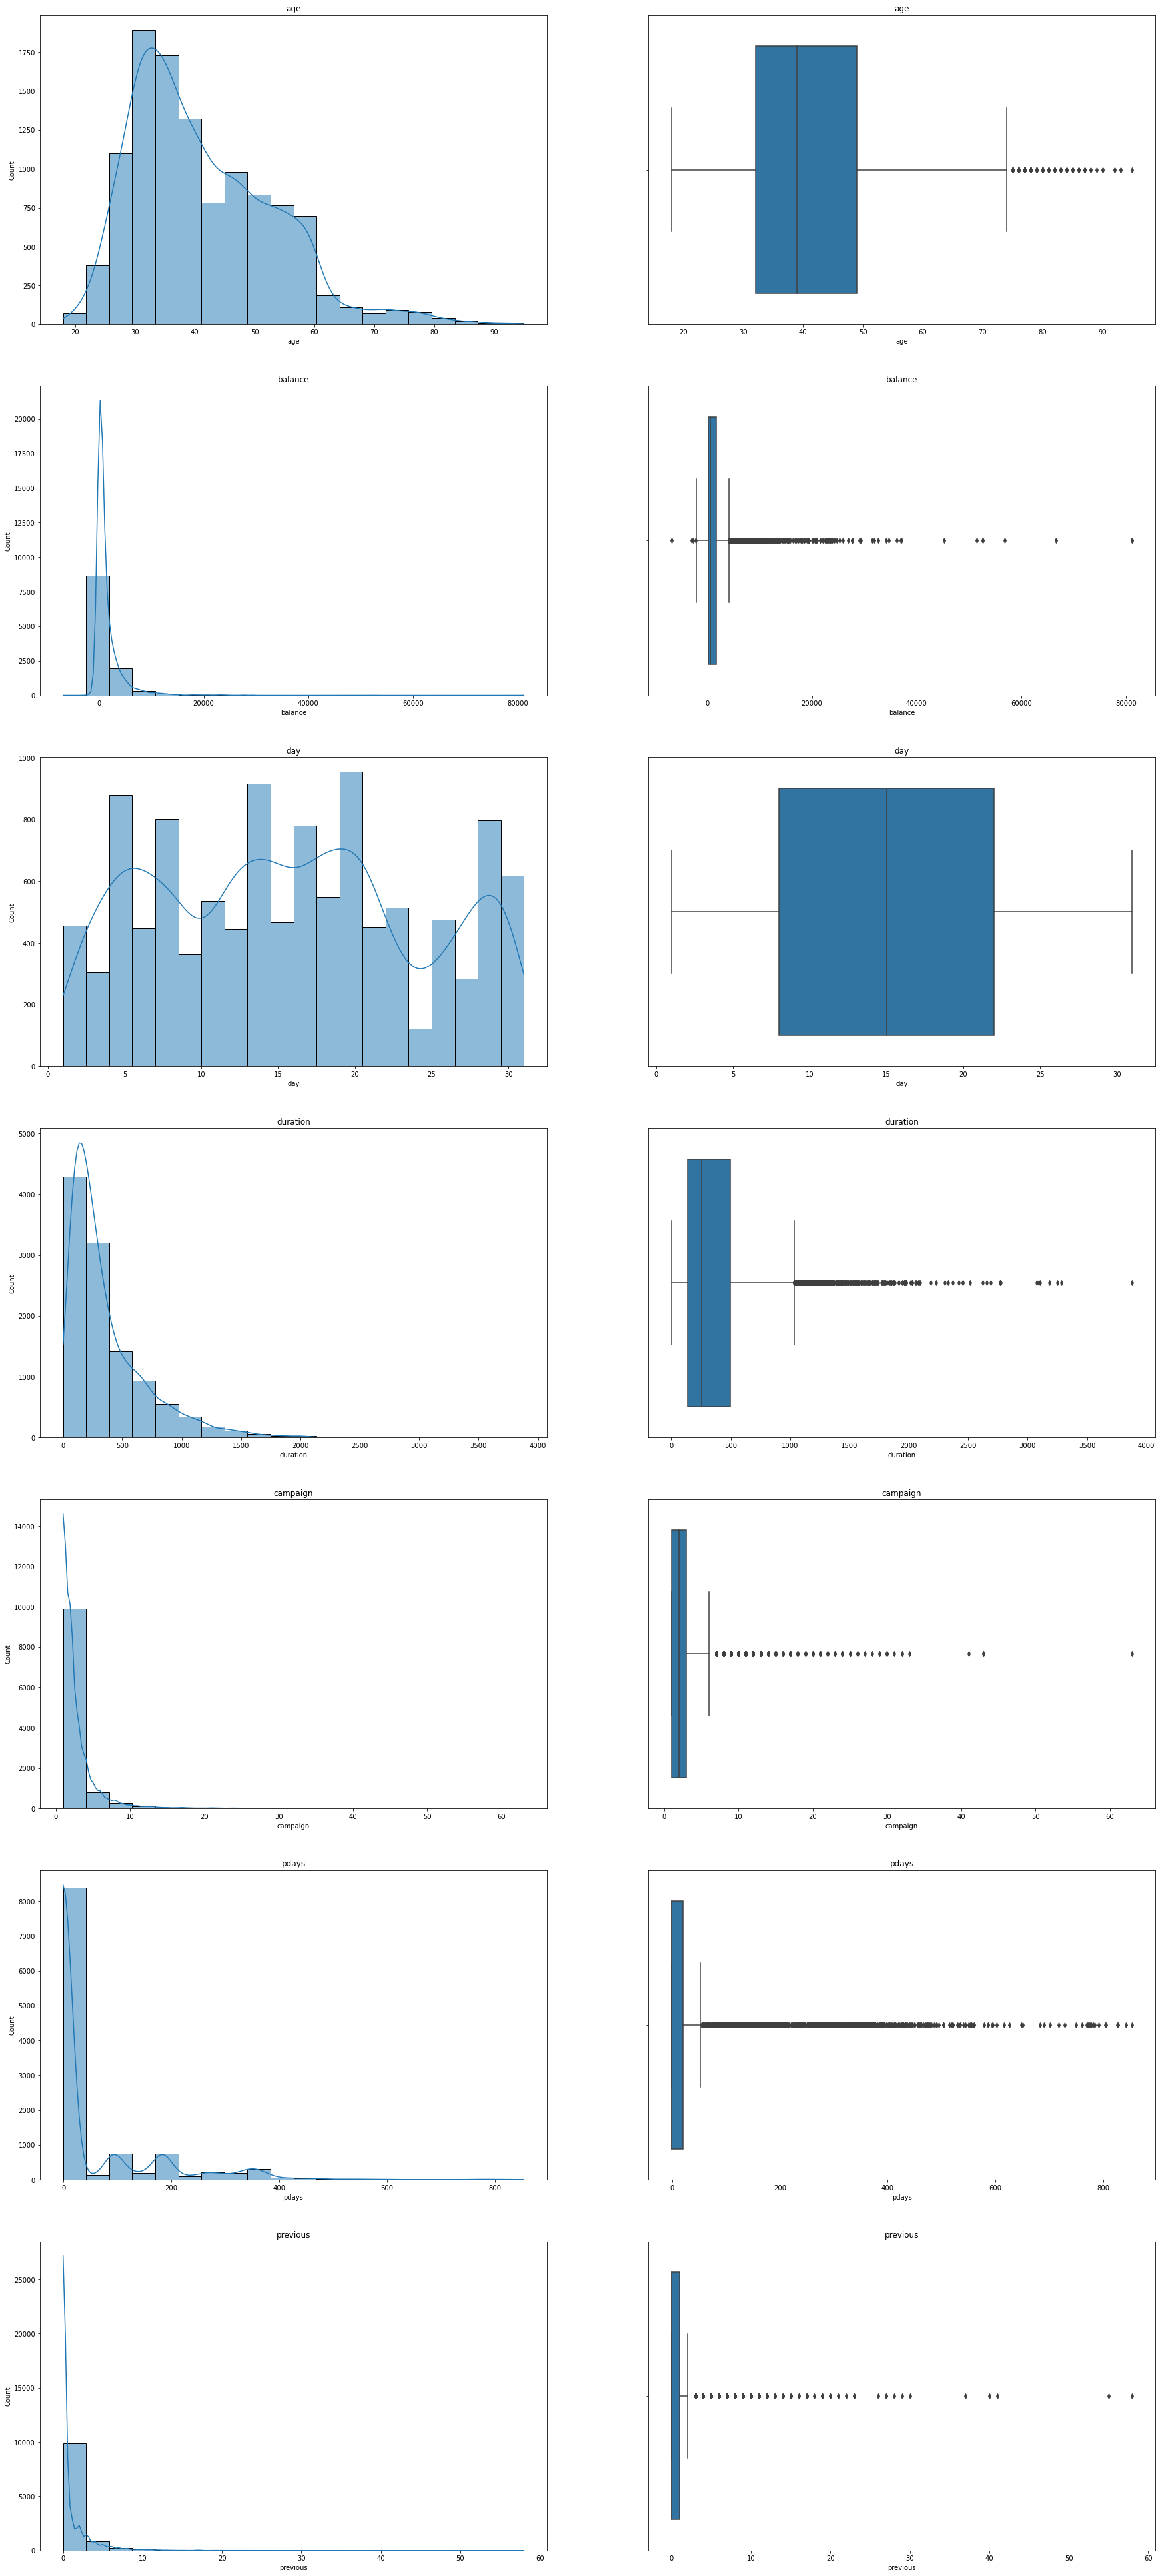

In [11]:
n = len(col_num)

fig, axes = plt.subplots(n, 2, figsize=(15*2,10*n), sharey=False)
for i in range(0,n):
    sns.histplot(data=data,x=col_num[i],bins=20, kde = True, ax=axes[i,0])
    axes[i,0].set_title(col_num[i])
    
    sns.boxplot(x = data[col_num[i]], ax = axes[i,1])
    axes[i,1].set_title(col_num[i])

In [12]:
data[col_num].describe()

age  balance      day  duration  campaign    pdays  previous
count 11162.00 11162.00 11162.00  11162.00  11162.00 11162.00  11162.00
mean     41.23  1528.54    15.66    371.99      2.51    51.33      0.83
std      11.91  3225.41     8.42    347.13      2.72   108.76      2.29
min      18.00 -6847.00     1.00      2.00      1.00    -1.00      0.00
25%      32.00   122.00     8.00    138.00      1.00    -1.00      0.00
50%      39.00   550.00    15.00    255.00      2.00    -1.00      0.00
75%      49.00  1708.00    22.00    496.00      3.00    20.75      1.00
max      95.00 81204.00    31.00   3881.00     63.00   854.00     58.00

In [13]:
px.box(data, x="deposit", y ="balance", width=800, height=600)

In [14]:
data['balance_range'] = pd.cut(data['balance'], bins=[5000,10000,20000,40000, np.inf], labels=['5000_to_10000','10000_to_20000','20000_to_40000','over_40000']) 
aux = data.groupby(['balance_range','deposit']).count()
aux['value'] = round(aux.iloc[:,0]*100/data.shape[0],2).to_frame()
aux.reset_index(inplace=True)
fig = px.bar(aux, x='balance_range', y = 'value', color='deposit', height=800,width=800,text = 'value')
fig.update_traces(textfont_size=20, textangle=0, textposition="outside")
fig.update_layout(title_text = "Distribution of balance", 
                       yaxis = dict(title='Percentage of data',titlefont_size=16,tickfont_size=14),
                       xaxis = dict(title='balance',titlefont_size=16,tickfont_size=14))
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [15]:
fig = px.box(data, x="deposit", y ="duration", width=1200, height=600)
fig.show()

In [16]:
data.drop(data[data.balance>20000].index, inplace=True)
data.reset_index(inplace = True, drop =True)
data.drop('balance_range', axis=1, inplace = True)
data

age          job  marital  education default  balance housing loan  \
0       59       admin.  married  secondary      no     2343     yes   no   
1       56       admin.  married  secondary      no       45      no   no   
2       41   technician  married  secondary      no     1270     yes   no   
3       55     services  married  secondary      no     2476     yes   no   
4       54       admin.  married   tertiary      no      184      no   no   
...    ...          ...      ...        ...     ...      ...     ...  ...   
11100   33  blue-collar   single    primary      no        1     yes   no   
11101   39     services  married  secondary      no      733      no   no   
11102   32   technician   single  secondary      no       29      no   no   
11103   43   technician  married  secondary      no        0      no  yes   
11104   34   technician  married  secondary      no        0      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0           NaN    5   may      1042         1     -1         0      NaN   
1           NaN    5   may      1467         1     -1         0      NaN   
2           NaN    5   may      1389         1     -1         0      NaN   
3           NaN    5   may       579         1     -1         0      NaN   
4           NaN    5   may       673         2     -1         0      NaN   
...         ...  ...   ...       ...       ...    ...       ...      ...   
11100  cellular   20   apr       257         1     -1         0      NaN   
11101       NaN   16   jun        83         4     -1         0      NaN   
11102  cellular   19   aug       156         2     -1         0      NaN   
11103  cellular    8   may         9         2    172         5  failure   
11104  cellular    9   jul       628         1     -1         0      NaN   

      deposit  
0         yes  
1         yes  
2         yes  
3         yes  
4         yes  
...       ...  
11100      no  
11101      no  
11102      no  
11103      no  
11104      no  

[11105 rows x 17 columns]

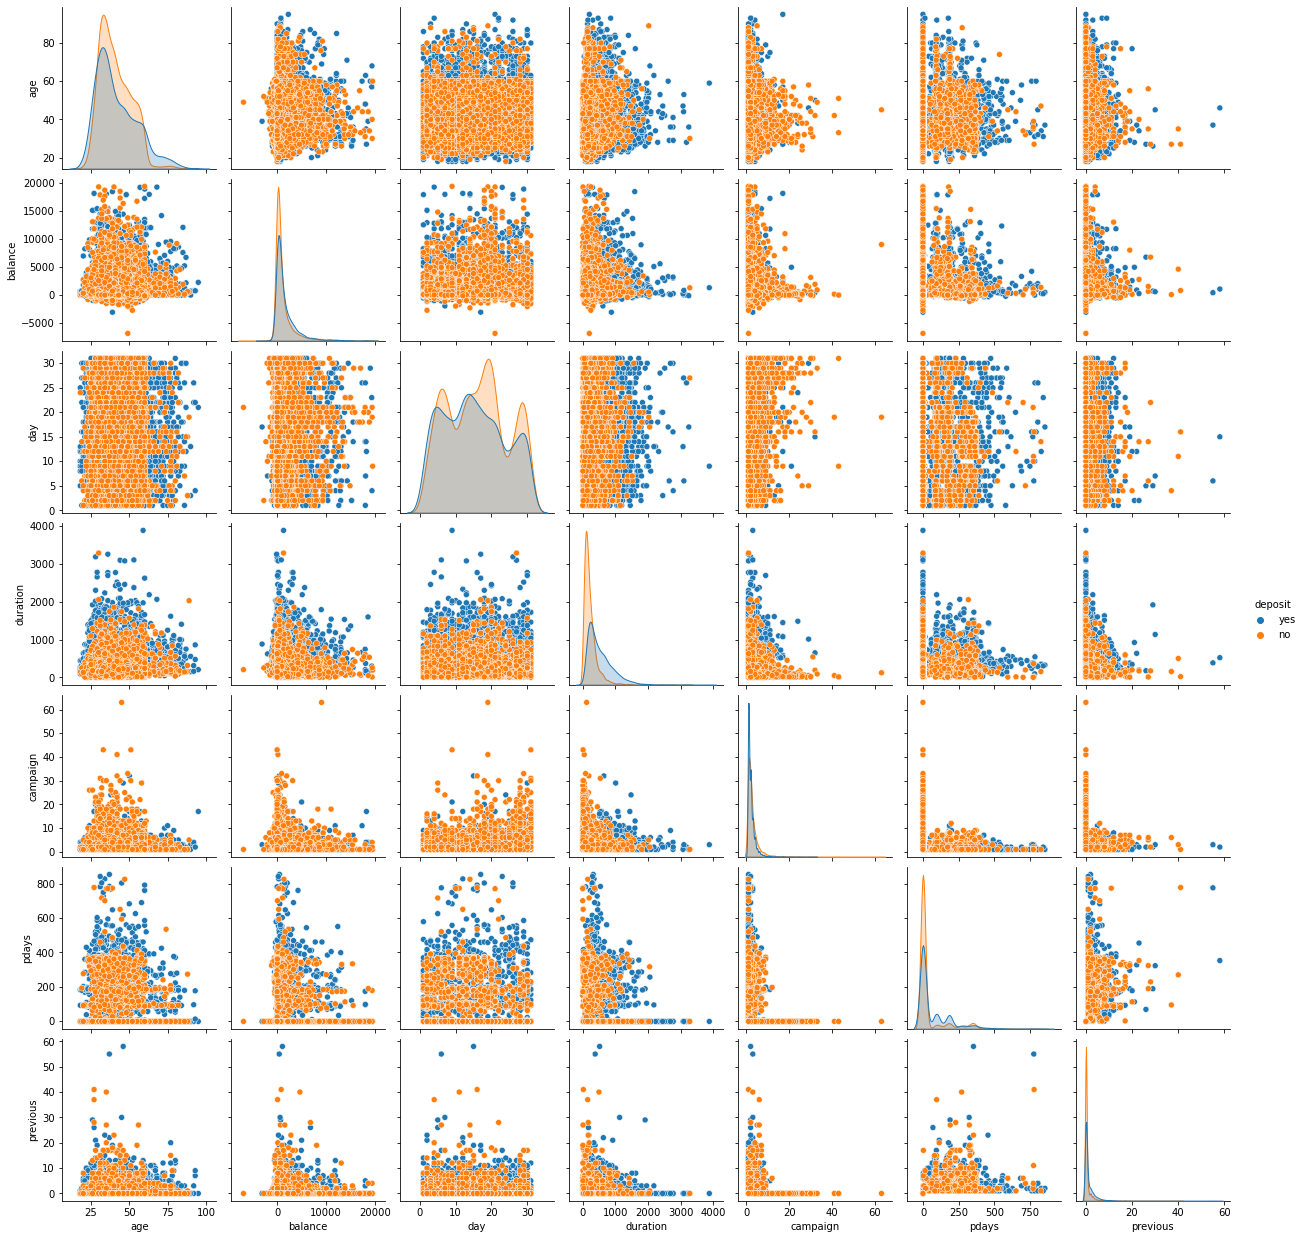

In [17]:
sns.pairplot(data, hue = 'deposit', dropna= True)

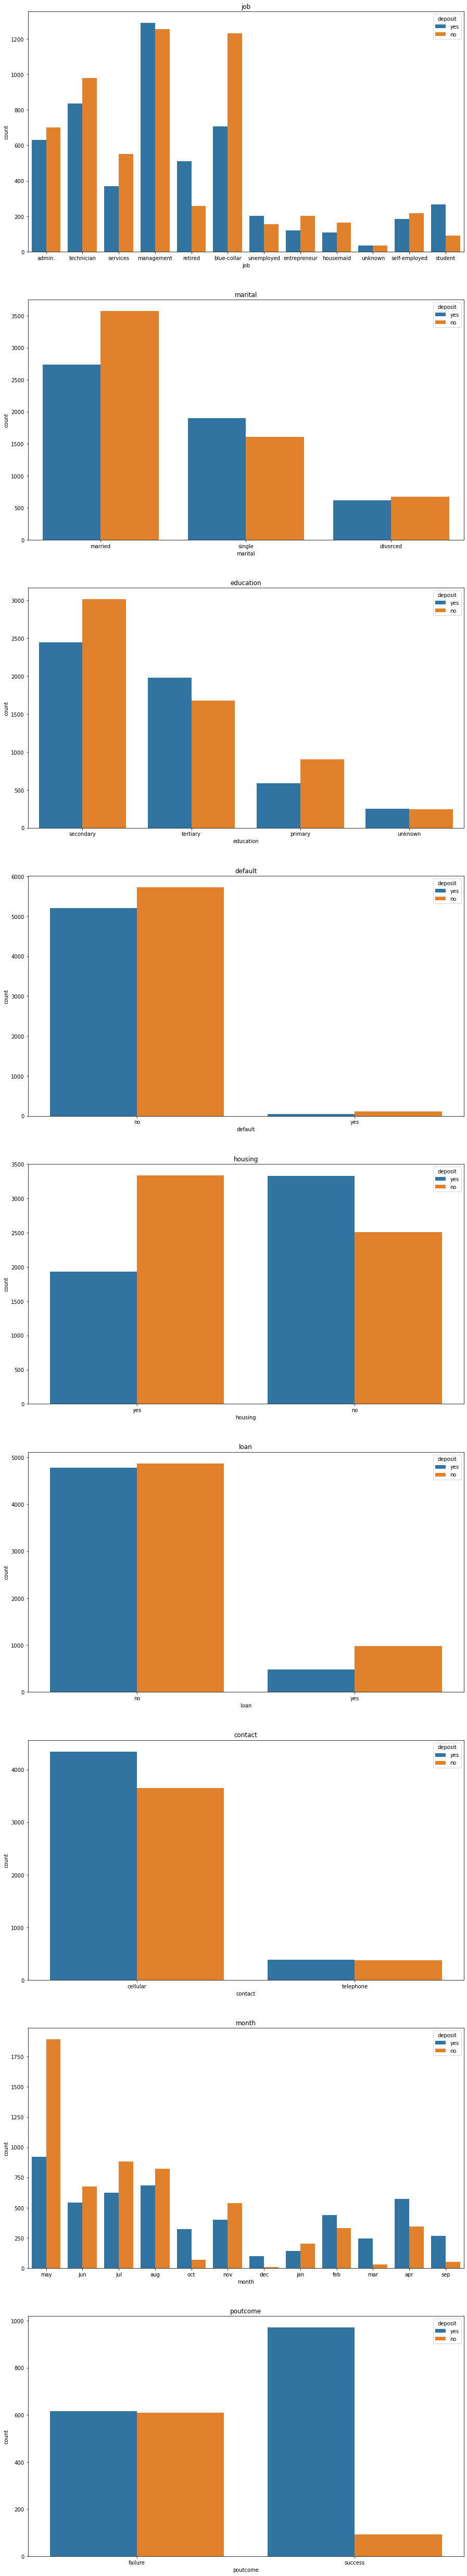

In [18]:
n = col_cat.shape[0]-1
fig, axes = plt.subplots(n, figsize=(15,10*n), sharey=False)

for i in range(0,n):
    sns.countplot(data=data, x=col_cat[i], hue='deposit',ax = axes[i]) 
    axes[i].set_title(col_cat[i])

In [19]:
def test_miss_validation(dataframe, miss_name_col,corr_name_col):
    rows = []
    for i in miss_name_col:
        cols = []
        for j in corr_name_col:
            miss_val = dataframe[dataframe[i]==False].groupby(j)[i].count()
            true_val = dataframe[dataframe[i]==True].groupby(j)[i].count()
            
            # Checking if the two lists have the same number of categories
            len_1 = len(true_val)
            len_2 = len(miss_val)
            if len_1 <len_2:
                mux = tuple(miss_val.index)
                true_val = true_val.reindex(mux, fill_value=0)

            if len_1 >=len_2:
                mux = tuple(true_val.index)
                miss_val = miss_val.reindex(mux, fill_value=0)
            
            
            table_validation = np.transpose([true_val.values, miss_val.values])
            p_value = chi2_contingency(table_validation)[1]
            cols.append(round(p_value,6))
        
        rows.append(cols)
    
    t_results = np.array(rows)
    df = pd.DataFrame(t_results, columns = corr_name_col, index =miss_name_col)
    return df

In [20]:
miss_names = ['poutcome_miss','contact_miss']
cat_test = col_cat.to_list()
cat_test.remove('poutcome')
cat_test.remove('contact')

data['poutcome_miss'] = data['poutcome']
data['poutcome_miss'] = False
data.loc[data[data['poutcome'].isnull()].index, "poutcome_miss"] = True 
##

data['contact_miss'] = data['contact']
data['contact_miss'] = False
data.loc[data[data['contact'].isnull()].index, "contact_miss"] = True

In [21]:
result_p = test_miss_validation(data, miss_names, cat_test)
result_p

job  marital  education  default  housing  loan  month  deposit
poutcome_miss 0.00     0.00       0.00     0.00     0.00  0.00   0.00     0.00
contact_miss  0.00     0.00       0.00     0.00     0.00  0.18   0.00     0.00

In [22]:
data[col_cat].head()

job  marital  education default housing loan contact month poutcome  \
0      admin.  married  secondary      no     yes   no     NaN   may      NaN   
1      admin.  married  secondary      no      no   no     NaN   may      NaN   
2  technician  married  secondary      no     yes   no     NaN   may      NaN   
3    services  married  secondary      no     yes   no     NaN   may      NaN   
4      admin.  married   tertiary      no      no   no     NaN   may      NaN   

  deposit  
0     yes  
1     yes  
2     yes  
3     yes  
4     yes

In [23]:
data_encoded = data.copy()
data_encoded.drop(columns = ['poutcome_miss','contact_miss'],inplace=True)
data_encoded = pd.get_dummies(data_encoded, columns = ['job', 'marital'])
data_encoded.head()

age  education default  balance housing loan contact  day month  duration  \
0   59  secondary      no     2343     yes   no     NaN    5   may      1042   
1   56  secondary      no       45      no   no     NaN    5   may      1467   
2   41  secondary      no     1270     yes   no     NaN    5   may      1389   
3   55  secondary      no     2476     yes   no     NaN    5   may       579   
4   54   tertiary      no      184      no   no     NaN    5   may       673   

   ...  job_retired  job_self-employed  job_services job_student  \
0  ...            0                  0             0           0   
1  ...            0                  0             0           0   
2  ...            0                  0             0           0   
3  ...            0                  0             1           0   
4  ...            0                  0             0           0   

  job_technician  job_unemployed  job_unknown  marital_divorced  \
0              0               0            0                 0   
1              0               0            0                 0   
2              1               0            0                 0   
3              0               0            0                 0   
4              0               0            0                 0   

   marital_married  marital_single  
0                1               0  
1                1               0  
2                1               0  
3                1               0  
4                1               0  

[5 rows x 30 columns]

In [24]:
data_encoded['education'] = data_encoded['education'].astype('category')
data_encoded['education']=data_encoded['education'].cat.codes
data_encoded['education']

0        1
1        1
2        1
3        1
4        2
        ..
11100    0
11101    1
11102    1
11103    1
11104    1
Name: education, Length: 11105, dtype: int8

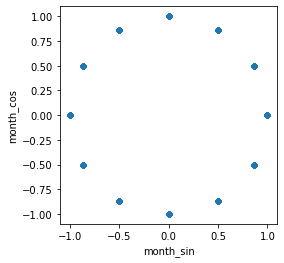

In [25]:
label_encoder = LabelEncoder()
data_encoded['month'] = label_encoder.fit_transform(data_encoded['month'])+1 # usando label encoder ele começa a transformação usando 0 não o 1

# Transformando a variável 'month' em sin e cos
max_val = data_encoded['month'].max()
data_encoded['month_sin'] = np.sin(2 * np.pi *data_encoded['month']/max_val)
data_encoded['month_cos'] = np.cos(2 * np.pi * data_encoded['month']/max_val)

# Transformando a variável 'day' em sin e cos
max_val = data_encoded['day'].max()
data_encoded['day_sin'] = np.sin(2 * np.pi *data_encoded['day']/max_val)
data_encoded['day_cos'] = np.cos(2 * np.pi * data_encoded['day']/max_val)

data_encoded.drop(columns = ['day','month'],inplace=True)

ax = data_encoded.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

In [26]:
name_cat =col_cat.to_list()
name_cat.remove('education')
name_cat.remove('job')
name_cat.remove('marital')
name_cat.remove('month')

data_encoded['poutcome'] = data_encoded['poutcome'].replace({np.NaN:'unknown'})
data_encoded['contact'] = data_encoded['contact'].replace({np.NaN:'unknown'})

label_encoder = LabelEncoder()

for i in name_cat:
    data_encoded[i] = label_encoder.fit_transform(data_encoded[i])
    
data_encoded['poutcome'].value_counts()

2    8816
0    1225
1    1064
Name: poutcome, dtype: int64

In [27]:
data_encoded['poutcome'] = data_encoded['poutcome'].replace(2,np.NaN)
data_encoded['contact'] = data_encoded['contact'].replace(2,np.NaN)

In [28]:
scaler = MinMaxScaler()
data_scaler = pd.DataFrame(scaler.fit_transform(data_encoded), columns = data_encoded.columns)
data_scaler.drop(columns = ['deposit'],inplace=True)
data_scaler.head()

age  education  default  balance  housing  loan  contact  duration  \
0 0.53       0.33     0.00     0.35     1.00  0.00      NaN      0.27   
1 0.49       0.33     0.00     0.26     0.00  0.00      NaN      0.38   
2 0.30       0.33     0.00     0.31     1.00  0.00      NaN      0.36   
3 0.48       0.33     0.00     0.35     1.00  0.00      NaN      0.15   
4 0.47       0.67     0.00     0.27     0.00  0.00      NaN      0.17   

   campaign  pdays  ...  job_technician  job_unemployed  job_unknown  \
0      0.00   0.00  ...            0.00            0.00         0.00   
1      0.00   0.00  ...            0.00            0.00         0.00   
2      0.00   0.00  ...            1.00            0.00         0.00   
3      0.00   0.00  ...            0.00            0.00         0.00   
4      0.02   0.00  ...            0.00            0.00         0.00   

   marital_divorced  marital_married  marital_single  month_sin  month_cos  \
0              0.00             1.00            0.00       0.00       0.50   
1              0.00             1.00            0.00       0.00       0.50   
2              0.00             1.00            0.00       0.00       0.50   
3              0.00             1.00            0.00       0.00       0.50   
4              0.00             1.00            0.00       0.00       0.50   

   day_sin  day_cos  
0     0.92     0.76  
1     0.92     0.76  
2     0.92     0.76  
3     0.92     0.76  
4     0.92     0.76  

[5 rows x 31 columns]

In [29]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=1000,random_state=0,n_nearest_features=None)

data_end = pd.DataFrame(imputer.fit_transform(data_scaler),columns = data_scaler.columns)

data_end['poutcome'] = data_end['poutcome'].round(decimals=0)
data_end['contact'] = data_end['contact'].round(decimals=0)
data_end['poutcome'].value_counts()

1.00    6781
0.00    4324
Name: poutcome, dtype: int64

In [30]:
data_end['contact'].value_counts()

0.00    10339
1.00      766
Name: contact, dtype: int64

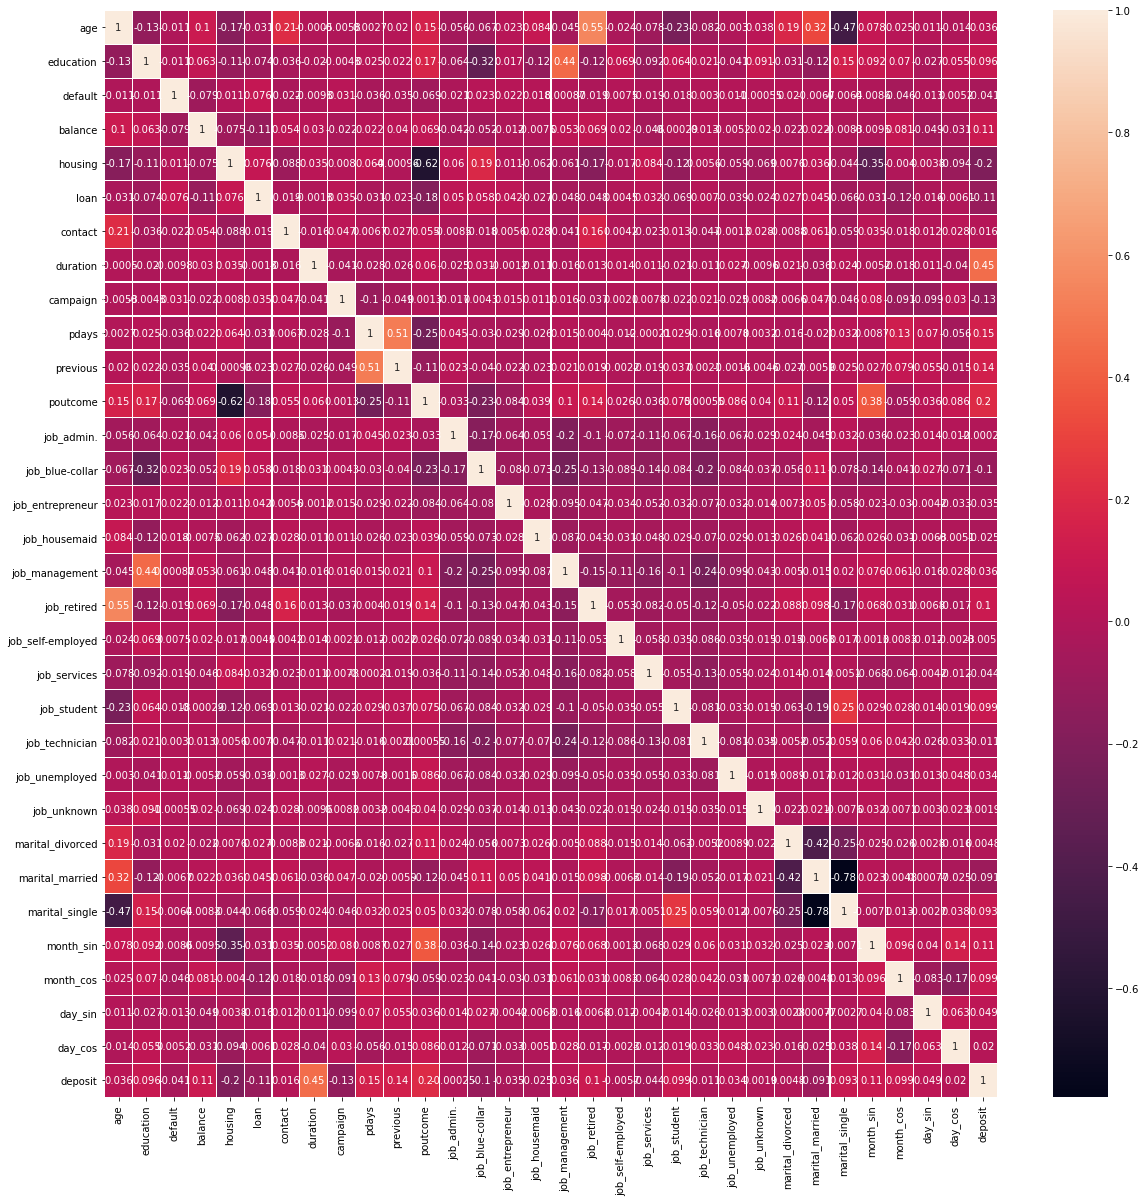

In [31]:
data_end['deposit'] = data_encoded['deposit']
fig, axes = plt.subplots(1, figsize=(20,20))
pearson_matrix = data_end.corr(method='pearson')
fig = sns.heatmap(pearson_matrix, annot=True,linewidths=.1)

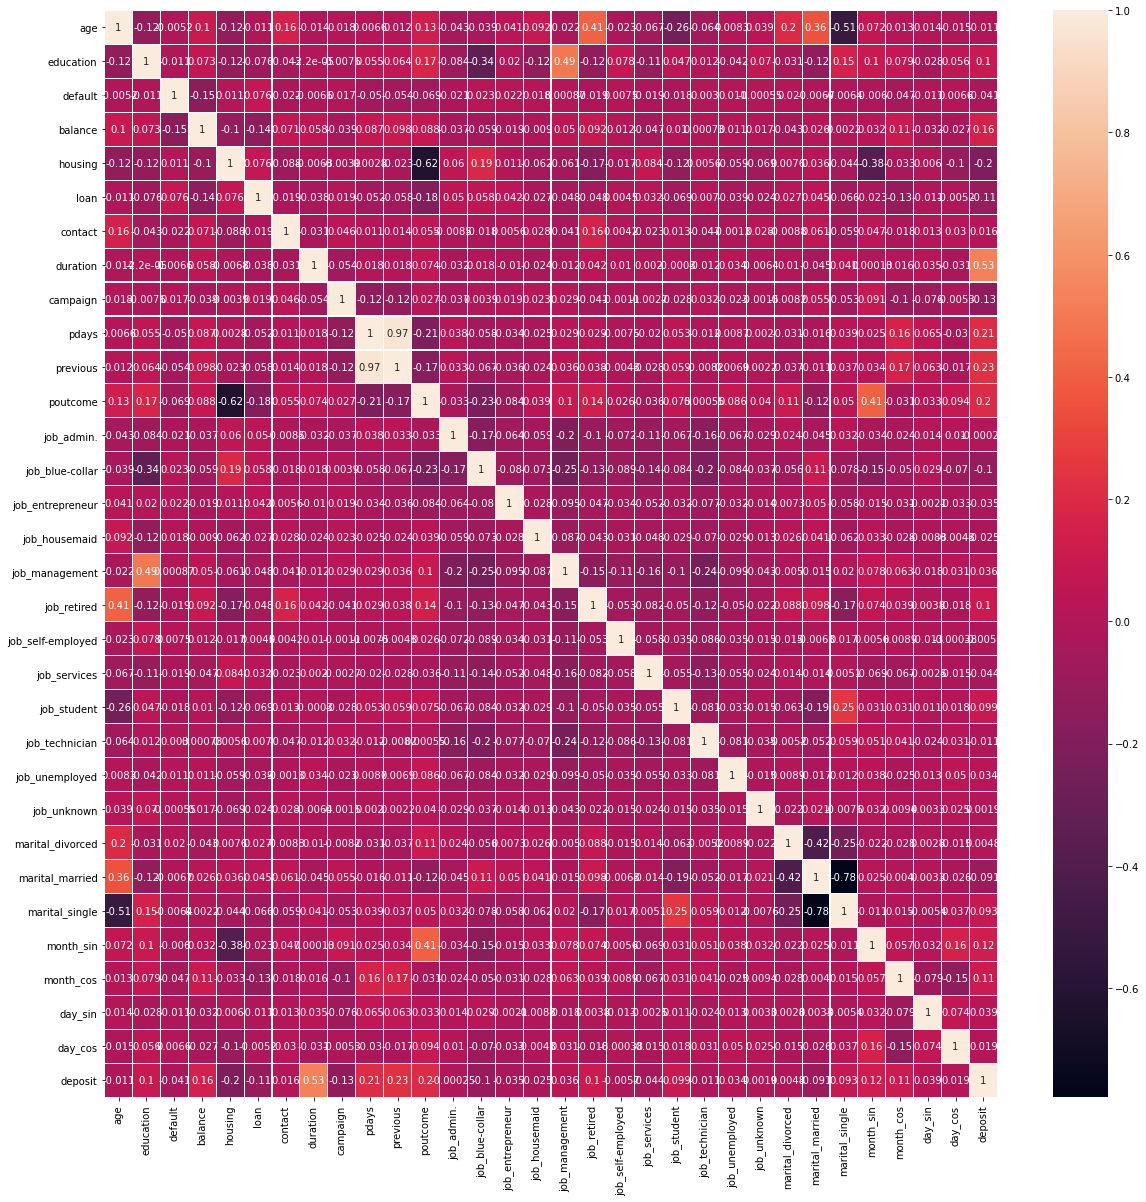

In [32]:
axes = plt.subplots(1, figsize=(20,20))
spearman_matrix = data_end.corr(method='spearman')
fig = sns.heatmap(spearman_matrix, annot=True,linewidths=.1)

In [33]:
data_end.drop(columns=['pdays','marital_single','deposit'],inplace = True)

In [34]:
X = data_end
y= data_encoded['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =0)

In [35]:
lazy_model = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=precision_score)
models,predictions = lazy_model.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:40<00:00,  1.39s/it]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.85               0.85     0.85      0.85   
RandomForestClassifier             0.85               0.85     0.85      0.85   
XGBClassifier                      0.84               0.84     0.84      0.84   
BaggingClassifier                  0.83               0.83     0.83      0.83   
ExtraTreesClassifier               0.82               0.82     0.82      0.82   
SVC                                0.81               0.81     0.81      0.81   
NuSVC                              0.80               0.80     0.80      0.80   
AdaBoostClassifier                 0.80               0.80     0.80      0.80   
LogisticRegression                 0.78               0.78     0.78      0.78   
CalibratedClassifierCV             0.78               0.78     0.78      0.78   
LinearSVC                          0.78               0.78     0.78      0.78   
SGDClassifier                      0.77               0.77     0.77      0.77   
DecisionTreeClassifier             0.76               0.76     0.76      0.76   
RidgeClassifier                    0.76               0.76     0.76      0.76   
LinearDiscriminantAnalysis         0.76               0.76     0.76      0.76   
RidgeClassifierCV                  0.76               0.76     0.76      0.76   
BernoulliNB                        0.75               0.75     0.75      0.75   
KNeighborsClassifier               0.74               0.74     0.74      0.74   
QuadraticDiscriminantAnalysis      0.74               0.74     0.74      0.74   
NearestCentroid                    0.73               0.73     0.73      0.73   
LabelSpreading                     0.72               0.71     0.71      0.72   
GaussianNB                         0.71               0.71     0.71      0.71   
LabelPropagation                   0.71               0.71     0.71      0.71   
ExtraTreeClassifier                0.69               0.69     0.69      0.69   
Perceptron                         0.67               0.67     0.67      0.67   
PassiveAggressiveClassifier        0.66               0.66     0.66      0.66   
DummyClassifier                    0.52               0.50     0.50      0.36   

                               precision_score  Time Taken  
Model                                                       
LGBMClassifier                            0.82        0.25  
RandomForestClassifier                    0.83        1.22  
XGBClassifier                             0.82        1.80  
BaggingClassifier                         0.81        0.49  
ExtraTreesClassifier                      0.80        1.20  
SVC                                       0.80        5.00  
NuSVC                                     0.80        6.69  
AdaBoostClassifier                        0.80        0.52  
LogisticRegression                        0.79        0.07  
CalibratedClassifierCV                    0.78        4.14  
LinearSVC                                 0.79        1.00  
SGDClassifier                             0.78        0.12  
DecisionTreeClassifier                    0.76        0.10  
RidgeClassifier                           0.78        0.05  
LinearDiscriminantAnalysis                0.78        0.11  
RidgeClassifierCV                         0.78        0.06  
BernoulliNB                               0.74        0.04  
KNeighborsClassifier                      0.75        0.63  
QuadraticDiscriminantAnalysis             0.76        0.10  
NearestCentroid                           0.71        0.04  
LabelSpreading                            0.72        8.97  
GaussianNB                                0.72        0.04  
LabelPropagation                          0.72        7.43  
ExtraTreeClassifier                       0.67        0.05  
Perceptron                                0.65        0.05  
PassiveAggressiveClassifier       

In [36]:
model_RF = Pipeline([('RF', RandomForestClassifier(random_state=0))])

In [37]:
def Objective_RF(trial):
    RF__max_depth = trial.suggest_int('RF__max_depth',200,800)
    RF__n_estimators = trial.suggest_int('RF__n_estimators',100,600)
    RF__min_samples_split = trial.suggest_int('RF__min_samples_split',2,20)
    RF__min_samples_leaf = trial.suggest_int('RF__min_samples_leaf',1,10)    
    RF__max_leaf_nodes = trial.suggest_int('RF__max_leaf_nodes',300,800)
    
    params = {
        'RF__max_depth': RF__max_depth,
        'RF__n_estimators':  RF__n_estimators,
        'RF__min_samples_split' : RF__min_samples_split,
        'RF__min_samples_leaf' : RF__min_samples_leaf,
        'RF__max_leaf_nodes' : RF__max_leaf_nodes
    }
    
    
    model = model_RF.set_params(**params)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    pre = precision_score(y_test,prediction)
    
    
    return pre

In [38]:
study_RF = optuna.create_study(directions = ["maximize"])
study_RF.optimize(Objective_RF, n_trials = 200, show_progress_bar = True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
plot_optimization_history(study_RF)

In [40]:
plot_slice(study_RF)

In [41]:
study_RF.best_trial.values

[0.8231111111111111]

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1159
           1       0.82      0.87      0.85      1062

    accuracy                           0.85      2221
   macro avg       0.85      0.85      0.85      2221
weighted avg       0.85      0.85      0.85      2221



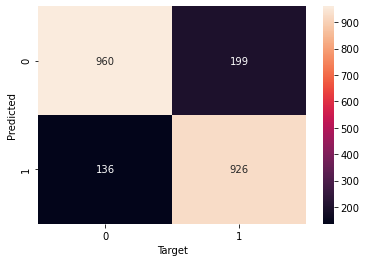

In [42]:
model = model_RF.set_params(**study_RF.best_params)
model.fit(X_train,y_train)
prediction = model.predict(X_test)


matrix=confusion_matrix(y_test,prediction)
df_cm = pd.DataFrame(matrix,index=['0','1'],columns=['0','1'])
s = sns.heatmap(df_cm, annot= True,fmt='g')
s.set(xlabel='Target', ylabel='Predicted')

report=classification_report(y_test,prediction)
print(report)

In [43]:
model_XGB = Pipeline([('XGB', XGBClassifier(random_state=0,eval_metric = 'auc') )])

In [44]:
def Objective_XGB(trial):
    n_estimators = trial.suggest_int('XGB__n_estimators',50,300)
    max_depth = trial.suggest_int('XGB__max_depth',10,400)
    max_leaves = trial.suggest_int('XGB__max_leaves',0,100)
    learning_rate = trial.suggest_float('XGB__learning_rate',0.0001,1)
    min_child_weight = trial.suggest_float('XGB__min_child_weight',0.001,10)
    max_delta_step = trial.suggest_float('XGB__max_delta_step',0.0001,1)
    reg_alpha = trial.suggest_float('XGB__reg_alpha',0,20)
    
    params = {
        'XGB__n_estimators' : n_estimators,
        'XGB__max_depth' : max_depth,
        'XGB__max_leaves' : max_leaves,
        'XGB__learning_rate' : learning_rate,
        'XGB__min_child_weight' : min_child_weight,
        'XGB__max_delta_step' : max_delta_step,
        'XGB__reg_alpha' : reg_alpha
    }
    
    model = model_XGB.set_params(**params)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    pre = precision_score(y_test,prediction)
    
    
    return pre  

In [45]:
study_XGB = optuna.create_study(directions = ["maximize"])
study_XGB.optimize(Objective_XGB, n_trials = 200, show_progress_bar = True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
plot_optimization_history(study_XGB)

In [47]:
plot_slice(study_XGB)

In [48]:
study_XGB.best_trial.values

[0.8322869955156951]

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1159
           1       0.83      0.87      0.85      1062

    accuracy                           0.86      2221
   macro avg       0.86      0.86      0.86      2221
weighted avg       0.86      0.86      0.86      2221



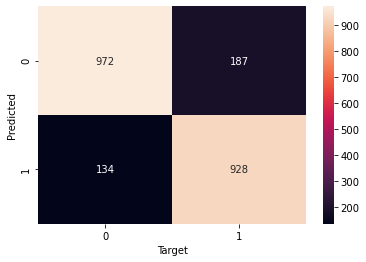

In [49]:
model = model_XGB.set_params(**study_XGB.best_params)

model.fit(X_train,y_train)
prediction = model.predict(X_test)

matrix=confusion_matrix(y_test,prediction)
df_cm = pd.DataFrame(matrix,index=['0','1'],columns=['0','1'])
s = sns.heatmap(df_cm, annot= True,fmt='g')
s.set(xlabel='Target', ylabel='Predicted')
report=classification_report(y_test,prediction)
print(report)

In [50]:
model_LGBM = Pipeline([('LGBM', LGBMClassifier(random_state=0, metric = "logloss"))])

In [51]:
def Objective_LGBM(trial):
    
    LGBM__boosting_type = trial.suggest_categorical('LGBM__boosting_type',['gbdt','dart','goss']) #pode dar erro por ter modelos diferentes
    LGBM__num_leaves = trial.suggest_int('LGBM__num_leaves',10,100)
    LGBM__max_depth = trial.suggest_int('LGBM__max_depth',-1,99,step=10)
    LGBM__learning_rate = trial.suggest_float('LGBM__learning_rate',0.001,1)
    LGBM__num_iterations = trial.suggest_int('LGBM__num_iterations',50,500,step = 50)
    LGBM__reg_alpha = trial.suggest_float('LGBM__reg_alpha',0,10)
    LGBM__reg_lambda = trial.suggest_float('LGBM__reg_lambda',0,10)
    
    
    params = {
        'LGBM__boosting_type' : LGBM__boosting_type,
        'LGBM__num_leaves' : LGBM__num_leaves,
        'LGBM__max_depth' : LGBM__max_depth,
        'LGBM__learning_rate' : LGBM__learning_rate,
        'LGBM__num_iterations' : LGBM__num_iterations,
        'LGBM__reg_alpha' : LGBM__reg_alpha,
        'LGBM__reg_lambda' : LGBM__reg_lambda, 
    }
    model = model_LGBM.set_params(**params)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    pre = precision_score(y_test,prediction)
    
    
    return pre

In [52]:
study_LGBM = optuna.create_study(directions = ["maximize"])
study_LGBM.optimize(Objective_LGBM, n_trials = 200, show_progress_bar = True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [53]:
plot_optimization_history(study_LGBM)

In [54]:
plot_slice(study_LGBM)

In [55]:
study_LGBM.best_trial.values

[0.8337801608579088]

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1159
           1       0.83      0.88      0.86      1062

    accuracy                           0.86      2221
   macro avg       0.86      0.86      0.86      2221
weighted avg       0.86      0.86      0.86      2221



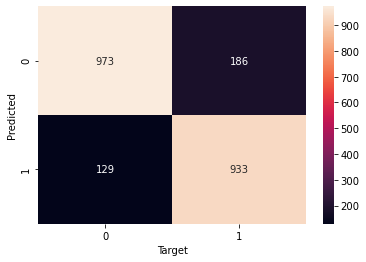

In [56]:
model = model_LGBM.set_params(**study_LGBM.best_params)
model.fit(X_train,y_train)
prediction = model.predict(X_test)

# Verificando a precisão do modelo
matrix=confusion_matrix(y_test,prediction)
df_cm = pd.DataFrame(matrix,index=['0','1'],columns=['0','1'])
s = sns.heatmap(df_cm, annot= True,fmt='g')
s.set(xlabel='Target', ylabel='Predicted')

report=classification_report(y_test,prediction)
print(report)

In [57]:
study_XGB.best_params

{'XGB__n_estimators': 112,
 'XGB__max_depth': 286,
 'XGB__max_leaves': 50,
 'XGB__learning_rate': 0.20445495346137227,
 'XGB__min_child_weight': 9.790980882337639,
 'XGB__max_delta_step': 0.8548042047819484,
 'XGB__reg_alpha': 7.055434775915435}

<BarContainer object of 29 artists>

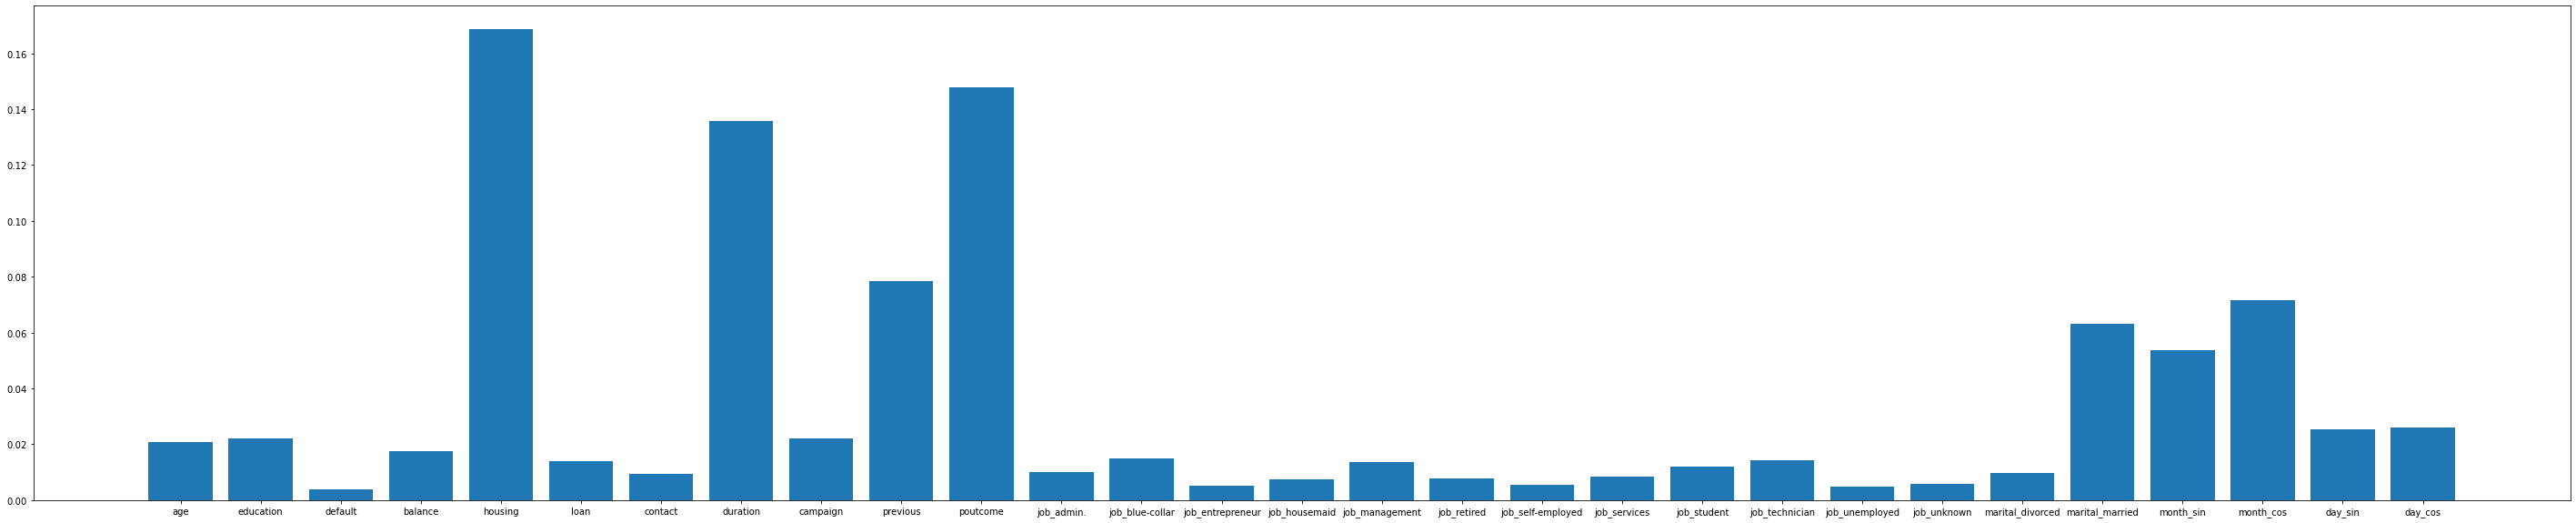

In [58]:
from xgboost import plot_importance
model_final = XGBClassifier(random_state =0, learning_rate = 0.698720134632314, n_estimators = 231, max_depth = 343, max_leaves = 67, min_child_weight = 0.8341364234312232,
                           max_delta_step = 0.07651183216848476, reg_alpha = 7.249554627471188)

model_final.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(50,10))
plt.bar(range(len(model_final.feature_importances_)), model_final.feature_importances_,tick_label = data_end.columns)